# PCA

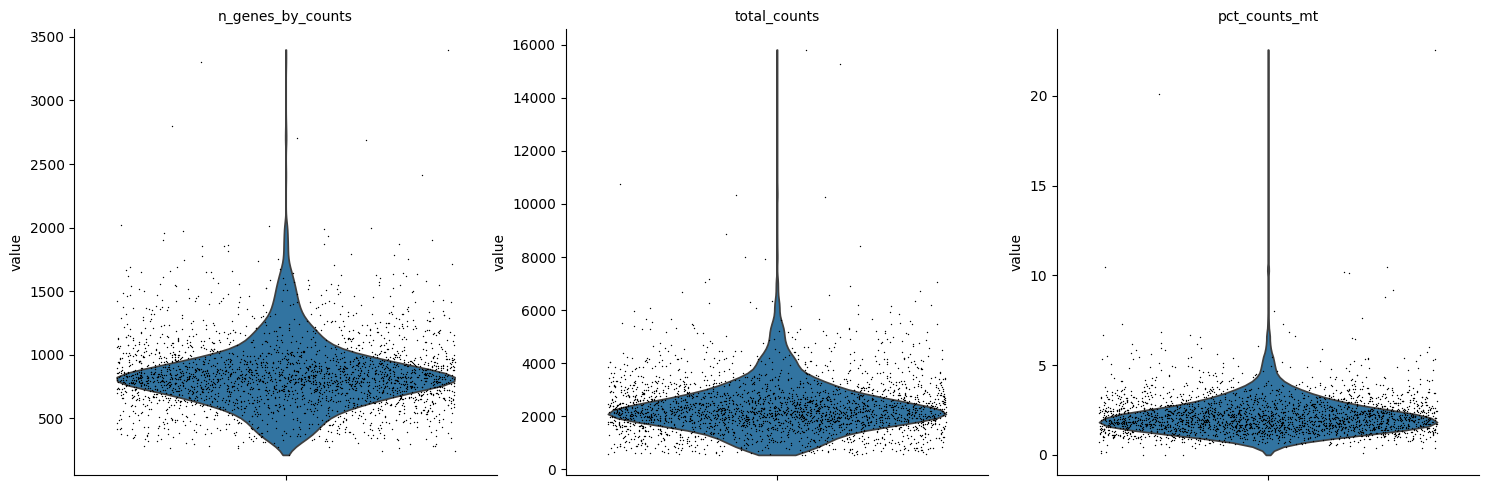

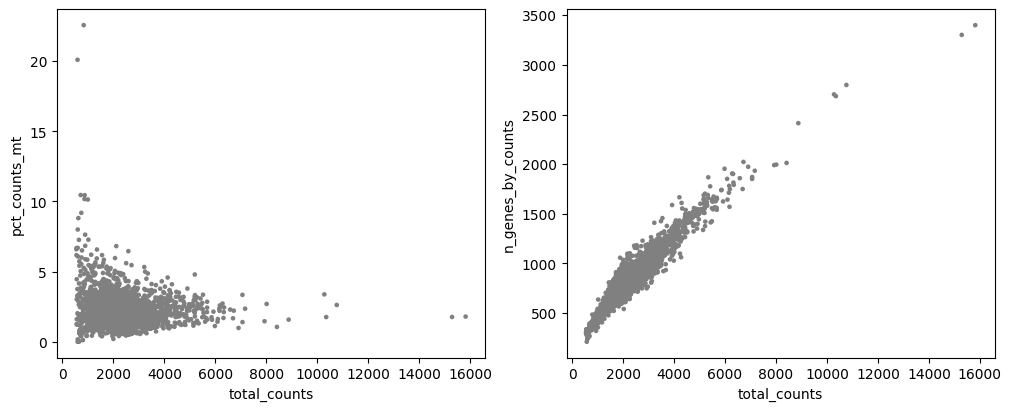

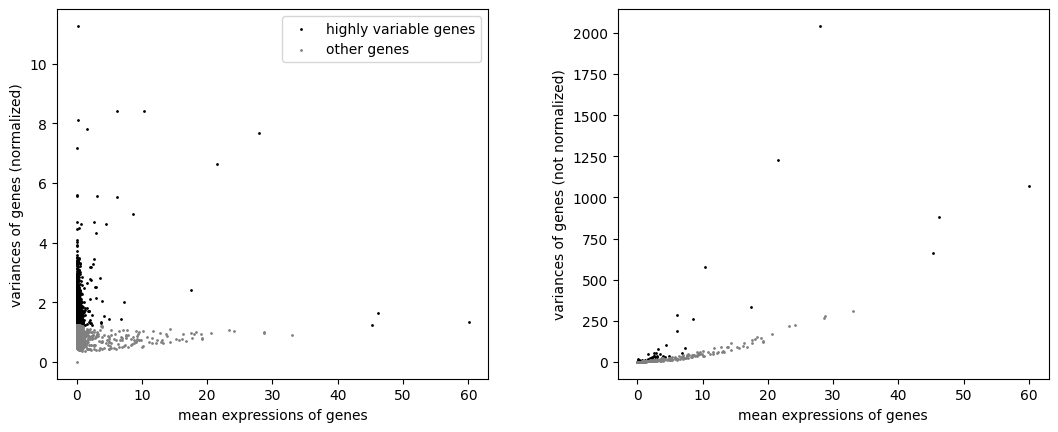

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'scaled'

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)


sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

sc.pl.highly_variable_genes(adata)


adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

adata

## sc.pp.pca()

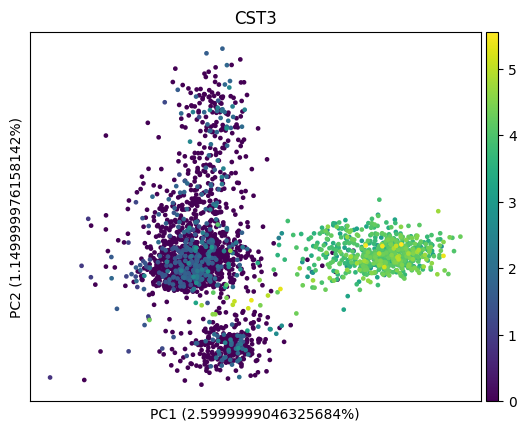

In [2]:
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")

sc.pl.pca(adata, annotate_var_explained=True, color="CST3")


In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'scaled'

In [ ]:
adata.obsm['X_pca'].shape

## 源码解析

### sc.pp.pca()源码

PCA分析结果，最终得到：
- 样本的主成分，adata.obsm['X_pca']
- 高变基因的主成分，adata.varm['PCs']
- 主成分分析的相关信息，adata.uns['pca']

In [ ]:
def pca(  # noqa: PLR0912, PLR0913, PLR0915
    data: AnnData | np.ndarray | CSBase,
    n_comps: int | None = None, # 维数，默认是50
    *,
    layer: str | None = None,   # 层，使用 scaled 数据
    zero_center: bool = True,
    svd_solver: SvdSolver | None = None,    # svd处理器，对于sparse矩阵，目前只支持：arpack，covariance_eigh
    chunked: bool = False,
    chunk_size: int | None = None,
    random_state: _LegacyRandom = 0,
    return_info: bool = False,
    mask_var: NDArray[np.bool_] | str | None | Empty = _empty,
    use_highly_variable: bool | None = None,
    dtype: DTypeLike = "float32",
    key_added: str | None = None,
    copy: bool = False,
) -> AnnData | np.ndarray | CSBase | None:
    r"""Principal component analysis :cite:p:`Pedregosa2011`.

    Computes PCA coordinates, loadings and variance decomposition.
    Uses the following implementations (and defaults for `svd_solver`):

    .. list-table::
       :header-rows: 1
       :stub-columns: 1
    """
    if return_anndata := isinstance(data, AnnData):
        if layer is None and not chunked and is_backed_type(data.X):
            msg = f"PCA is not implemented for matrices of type {type(data.X)} with chunked as False"
            raise NotImplementedError(msg)
        # 拷贝adata
        adata = data.copy() if copy else data
    
    # 使用高变基因做PCA分析
    mask_var_param, mask_var = _handle_mask_var(
        adata, mask_var, use_highly_variable=use_highly_variable
    )
    """
    (Pdb) p mask_var_param
    'highly_variable'
    (Pdb) p mask_var
    array([False, False, False, ..., False, False, False])
    (Pdb) sum(mask_var)
    np.int64(2000)
    """
    del use_highly_variable
    # 用 adata.var.highly_variable 过滤列，得到高变基因矩阵
    adata_comp = adata[:, mask_var] if mask_var is not None else adata

    # 确定维数
    # settings.N_PCS = 50，当 n_comps 为 None 时
    if n_comps is None:
        # 最小维数 = 细胞、基因数最小值
        min_dim = min(adata_comp.n_vars, adata_comp.n_obs)
        # 如果最小值小于 settings.N_PCS = 50，则 min_dim - -1，否则为 settings.N_PCS
        # 也就是说，最多50维。如果行列低于50维，则最低维数-1
        n_comps = min_dim - 1 if min_dim <= settings.N_PCS else settings.N_PCS

    # 选择指定层的数据，例子中是 scaled
    x = _get_obs_rep(adata_comp, layer=layer)

    # 检查随机状态
    # check_random_state returns a numpy RandomState when passed an int but
    # dask needs an int for random state
    if not isinstance(x, DaskArray):
        random_state = check_random_state(random_state)
    elif not isinstance(random_state, int):
        msg = f"random_state needs to be an int, not a {type(random_state).__name__} when passing a dask array"
        raise TypeError(msg)

    # PCA
    if chunked:
        pass
    elif zero_center:
        if isinstance(x, CSBase) and (
            pkg_version("scikit-learn") < Version("1.4") or svd_solver == "lobpcg"
        ):
            pass
        else:
            if not isinstance(x, DaskArray):
                # 从 sklearn 导入 PCA 类
                from sklearn.decomposition import PCA

                svd_solver = _handle_sklearn_args(
                    svd_solver, PCA, sparse=isinstance(x, CSBase)
                )
                """
                (Pdb) p n_comps
                50
                (Pdb) svd_solver
                'arpack'
                (Pdb) p random_state
                RandomState(MT19937) at 0x13A768940
                """
                pca_ = PCA(
                    n_components=n_comps,
                    svd_solver=svd_solver,
                    random_state=random_state,
                )
                """
                (Pdb) pca_
                PCA(n_components=50, random_state=RandomState(MT19937) at 0x13A768940,
                    svd_solver='arpack')
                (Pdb)
                """
            elif isinstance(x._meta, CSBase) or svd_solver == "covariance_eigh":
                pca_ = PCAEighDask(n_components=n_comps)
            else:
                pca_ = PCA()
            x_pca = pca_.fit_transform(x)
    else:
        pass

    if return_anndata:
        key_obsm, key_varm, key_uns = (
            ("X_pca", "PCs", "pca") if key_added is None else [key_added] * 3
        )
        # obsm['X_pca]保存原始PCA结果
        adata.obsm[key_obsm] = x_pca

        # 如果使用了高变基因
        if mask_var is not None:
            # 则首先创建所有基因的行数，主成分数形状的矩阵
            # (Pdb) p adata.varm[key_varm].shape
            # (13714, 50)
            adata.varm[key_varm] = np.zeros(shape=(adata.n_vars, n_comps))
            # 为每一个高变基因标记主成分结果，每一个基因对每一个主成分有贡献
            adata.varm[key_varm][mask_var] = pca_.components_.T
        else:
            adata.varm[key_varm] = pca_.components_.T

        # 将非结构化的信息保存到 adata.uns 字典中
        params = dict(
            zero_center=zero_center,
            use_highly_variable=mask_var_param == "highly_variable",
            mask_var=mask_var_param,
        )
        if layer is not None:
            params["layer"] = layer
        adata.uns[key_uns] = dict(
            params=params,
            variance=pca_.explained_variance_,
            variance_ratio=pca_.explained_variance_ratio_,
        )
        """
        (Pdb) adata.uns['pca']
        {'params': {'zero_center': True, 'use_highly_variable': True, 'mask_var': 'highly_variable', 'layer': 'scaled'}, 'variance': array([45.141766 , 19.876654 , 14.983556 , 14.205607 ,  7.391644 ,
                4.6135287,  3.9836595,  3.5960653,  3.4629772,  3.3924685,
                3.2902029,  3.2063644,  3.155856 ,  3.1223814,  3.0894763,
                3.042899 ,  3.0209327,  3.0159883,  2.9850717,  2.9785855,
                2.968434 ,  2.9507434,  2.9387796,  2.9299324,  2.922011 ,
                2.9135363,  2.9107304,  2.896431 ,  2.8889797,  2.8698208,
                2.8606422,  2.843496 ,  2.8397598,  2.829533 ,  2.82614  ,
                2.8178477,  2.8079383,  2.7970679,  2.7926745,  2.7791917,
                2.775702 ,  2.764986 ,  2.7587636,  2.7554576,  2.7480307,
                2.7395234,  2.7291794,  2.7218006,  2.7203758,  2.7125065],
            dtype=float32), 'variance_ratio': array([0.02602983, 0.01146135, 0.00863988, 0.00819129, 0.0042622 ,
            0.00266027, 0.00229707, 0.00207358, 0.00199684, 0.00195618,
            0.00189721, 0.00184887, 0.00181974, 0.00180044, 0.00178147,
            0.00175461, 0.00174194, 0.00173909, 0.00172126, 0.00171752,
            0.00171167, 0.00170147, 0.00169457, 0.00168947, 0.0016849 ,
            0.00168001, 0.0016784 , 0.00167015, 0.00166585, 0.00165481,
            0.00164951, 0.00163963, 0.00163747, 0.00163158, 0.00162962,
            0.00162484, 0.00161912, 0.00161286, 0.00161032, 0.00160255,
            0.00160054, 0.00159436, 0.00159077, 0.00158886, 0.00158458,
            0.00157967, 0.00157371, 0.00156946, 0.00156863, 0.0015641 ],
            dtype=float32)}
        """
        logg.info("    finished", time=logg_start)
        logg.debug(
            "and added\n"
            f"    {key_obsm!r}, the PCA coordinates (adata.obs)\n"
            f"    {key_varm!r}, the loadings (adata.varm)\n"
            f"    'pca_variance', the variance / eigenvalues (adata.uns[{key_uns!r}])\n"
            f"    'pca_variance_ratio', the variance ratio (adata.uns[{key_uns!r}])"
        )
        return adata if copy else None
    else:
        logg.info("    finished", time=logg_start)
        if return_info:
            return (
                x_pca,
                pca_.components_,
                pca_.explained_variance_ratio_,
                pca_.explained_variance_,
            )
        else:
            return x_pca

### sc.pl.pca()源码

会使用 adata.obsm['X_pca']的数据画散点图，并用基因或其他变量标记点的颜色。

每个主成分的解释比较会作为x, y轴的标签。

PCA是将高变基因降维，比如50维，然后可以用一维作为一个轴，进行画散点图。

细胞的维度变化：

3万个基因，过滤，剩下1万多个，选择2000个高变基因，成2000维，再PCA降到50维，散点图利用2维主成分。

在散点图中，每一个细胞从几万维，降到了2维。

主成分，解释了细胞之间的差异。

In [ ]:
def pca(
    adata: AnnData,
    *,
    annotate_var_explained: bool = False,
    show: bool | None = None,
    return_fig: bool | None = None,
    save: bool | str | None = None,
    **kwargs,
) -> Figure | Axes | list[Axes] | None:
    """Scatter plot in PCA coordinates.
    PCA其实是画散点图。

   annotate_var_explained, 为True，使用PCA降维后的数据作图。

    """
    # 如果没设置annotate_var_explained，则不使用PCA降维结果。
    if not annotate_var_explained:
        return embedding(
            adata, "pca", show=show, return_fig=return_fig, save=save, **kwargs
        )
    
    # 如果设置了annotate_var_explained，则使用 adata.obsm中的PCA结果，没有相应结果则报错。
    if "pca" not in adata.obsm and "X_pca" not in adata.obsm:
        msg = (
            f"Could not find entry in `obsm` for 'pca'.\n"
            f"Available keys are: {list(adata.obsm.keys())}."
        )
        raise KeyError(msg)
    """
    生成每个主成分的标签。
    variance_ratio 是每一个主成分的解释比例，共50个:
    (Pdb) adata.uns["pca"]["variance_ratio"]
    array([0.02602983, 0.01146135, 0.00863988, 0.00819129, 0.0042622 ,
        0.00266027, 0.00229707, 0.00207358, 0.00199684, 0.00195618,
        0.00189721, 0.00184887, 0.00181974, 0.00180044, 0.00178147,
        0.00175461, 0.00174194, 0.00173909, 0.00172126, 0.00171752,
        0.00171167, 0.00170147, 0.00169457, 0.00168947, 0.0016849 ,
        0.00168001, 0.0016784 , 0.00167015, 0.00166585, 0.00165481,
        0.00164951, 0.00163963, 0.00163747, 0.00163158, 0.00162962,
        0.00162484, 0.00161912, 0.00161286, 0.00161032, 0.00160255,
        0.00160054, 0.00159436, 0.00159077, 0.00158886, 0.00158458,
        0.00157967, 0.00157371, 0.00156946, 0.00156863, 0.0015641 ],
        dtype=float32)
    (Pdb) len(adata.uns["pca"]["variance_ratio"])
    50

    (Pdb) p label_dict
    {'PC1': 'PC1 (2.5999999046325684%)', 'PC2': 'PC2 (1.149999976158142%)', 'PC3': 'PC3 (0.8600000143051147%)', 'PC4': 'PC4 (0.8199999928474426%)', 'PC5': 'PC5 (0.4300000071525574%)', 'PC6': 'PC6 (0.27000001072883606%)', 'PC7': 'PC7 (0.23000000417232513%)', 'PC8': 'PC8 (0.20999999344348907%)', 'PC9': 'PC9 (0.20000000298023224%)', 'PC10': 'PC10 (0.20000000298023224%)', 'PC11': 'PC11 (0.1899999976158142%)', 'PC12': 'PC12 (0.18000000715255737%)', 'PC13': 'PC13 (0.18000000715255737%)', 'PC14': 'PC14 (0.18000000715255737%)', 'PC15': 'PC15 (0.18000000715255737%)', 'PC16': 'PC16 (0.18000000715255737%)', 'PC17': 'PC17 (0.17000000178813934%)', 'PC18': 'PC18 (0.17000000178813934%)', 'PC19': 'PC19 (0.17000000178813934%)', 'PC20': 'PC20 (0.17000000178813934%)', 'PC21': 'PC21 (0.17000000178813934%)', 'PC22': 'PC22 (0.17000000178813934%)', 'PC23': 'PC23 (0.17000000178813934%)', 'PC24': 'PC24 (0.17000000178813934%)', 'PC25': 'PC25 (0.17000000178813934%)', 'PC26': 'PC26 (0.17000000178813934%)', 'PC27': 'PC27 (0.17000000178813934%)', 'PC28': 'PC28 (0.17000000178813934%)', 'PC29': 'PC29 (0.17000000178813934%)', 'PC30': 'PC30 (0.17000000178813934%)', 'PC31': 'PC31 (0.1599999964237213%)', 'PC32': 'PC32 (0.1599999964237213%)', 'PC33': 'PC33 (0.1599999964237213%)', 'PC34': 'PC34 (0.1599999964237213%)', 'PC35': 'PC35 (0.1599999964237213%)', 'PC36': 'PC36 (0.1599999964237213%)', 'PC37': 'PC37 (0.1599999964237213%)', 'PC38': 'PC38 (0.1599999964237213%)', 'PC39': 'PC39 (0.1599999964237213%)', 'PC40': 'PC40 (0.1599999964237213%)', 'PC41': 'PC41 (0.1599999964237213%)', 'PC42': 'PC42 (0.1599999964237213%)', 'PC43': 'PC43 (0.1599999964237213%)', 'PC44': 'PC44 (0.1599999964237213%)', 'PC45': 'PC45 (0.1599999964237213%)', 'PC46': 'PC46 (0.1599999964237213%)', 'PC47': 'PC47 (0.1599999964237213%)', 'PC48': 'PC48 (0.1599999964237213%)', 'PC49': 'PC49 (0.1599999964237213%)', 'PC50': 'PC50 (0.1599999964237213%)'}
    (Pdb) len(label_dict.keys())
    50
    """
    label_dict = {
        f"PC{i + 1}": f"PC{i + 1} ({round(v * 100, 2)}%)"
        for i, v in enumerate(adata.uns["pca"]["variance_ratio"])
    }

    # 如果返回图片，测试是 None
    if return_fig is True:
        # edit axis labels in returned figure
        fig = embedding(adata, "pca", return_fig=return_fig, **kwargs)
        for ax in fig.axes:
            if xlabel := label_dict.get(ax.xaxis.get_label().get_text()):
                ax.set_xlabel(xlabel)
            if ylabel := label_dict.get(ax.yaxis.get_label().get_text()):
                ax.set_ylabel(ylabel)
        return fig

    # 进行绘图
    # get the axs, edit the labels and apply show and save from user
    axs = embedding(adata, "pca", show=False, save=False, **kwargs)
    # 如果返回的是列表，则为每一个图设置x, y标签
    if isinstance(axs, list):
        for ax in axs:
            ax.set_xlabel(label_dict[ax.xaxis.get_label().get_text()])
            ax.set_ylabel(label_dict[ax.yaxis.get_label().get_text()])
    else:
        # 如果不是列表，是单个图，则为其设置x, y标签
        axs.set_xlabel(label_dict[axs.xaxis.get_label().get_text()])
        axs.set_ylabel(label_dict[axs.yaxis.get_label().get_text()])
    
    # 保存或显示图片
    _utils.savefig_or_show("pca", show=show, save=save)
    show = settings.autoshow if show is None else show
    if show:
        return None
    return axs

### embedding()源码

In [ ]:
def embedding(
    adata: AnnData,
    basis: str, # 偏好，obsm 中键的名称
    *,
    color: str | Sequence[str] | None = None,
    show: bool | None = None,
    save: bool | str | None = None,
):
    """Scatter plot for user specified embedding basis (e.g. umap, pca, etc).
    画用户指定的散点图。
    """

    """
    提取用于绘图的矩阵
    (Pdb) basis_values.shape
    (2638, 50)
    """
    basis_values = _get_basis(adata, basis)


def _get_basis(adata: AnnData, basis: str) -> np.ndarray:
    """Get array for basis from anndata. Just tries to add 'X_'."""
    if basis in adata.obsm:
        return adata.obsm[basis]
    elif f"X_{basis}" in adata.obsm:
        # 测试，返回 adata.obsm['X_pca]
        return adata.obsm[f"X_{basis}"]
    else:
        msg = f"Could not find {basis!r} or 'X_{basis}' in .obsm"
        raise KeyError(msg)

In [8]:
round(0.000999999, 2)

0.0